In [13]:
from os.path import exists

import config
from dataloader.loader import Loader
import pandas as pd
from gensim.models import word2vec
import nltk

In [14]:
unsupervised = pd.read_csv(config.IMDB_DATA_CSV + '/movie_reviews_unsup.csv', encoding='ISO-8859-1')
train_df = pd.read_csv(config.IMDB_DATA_CSV + '/movie_reviews_train.csv', encoding='ISO-8859-1')
test_df = pd.read_csv(config.IMDB_DATA_CSV + '/movie_reviews_test.csv', encoding='ISO-8859-1')

In [15]:
corpus = unsupervised['review'].tolist() + train_df['review'].tolist() + test_df['review'].tolist()

In [16]:
# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document.lower()) for document in corpus]

In [17]:
# Set values for various parameters
feature_size = 50           # Word vector dimensionality
window_context = 10         # Context window size
min_word_count = 5          # Minimum word count
sample = 1e-3               # Downsample setting for frequent words

In [18]:
w2v_model = word2vec.Word2Vec(tokenized_corpus, window=window_context, min_count=min_word_count, sample=sample)

In [19]:
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in [
                     'good','superior','violent', 'romantic', 'nasty', 'unfortunate',
                     'predictable', 'hilarious', 'fascinating', 'boring','confused', 'sensitive',
                     'imaginative','senseless', 'bland','disappointing']}

In [20]:
similar_words

{'good': ['bad', 'decent', 'great', 'passable', 'nice'],
 'superior': ['inferior', 'exceeds', 'surpasses', 'fetched', 'lesser'],
 'violent': ['brutal', 'violence', 'gruesome', 'sadistic', 'sickening'],
 'romantic': ['romance', 'screwball', 'drama', 'quirky', 'charming'],
 'nasty': ['gruesome', 'sadistic', 'gory', 'sleazy', 'bloody'],
 'unfortunate': ['unacceptable', 'important', 'immoral', 'error', 'obvious'],
 'predictable': ['formulaic', 'contrived', 'unoriginal', 'corny', 'trite'],
 'hilarious': ['hysterical', 'funny', 'priceless', 'comical', 'amusing'],
 'fascinating': ['compelling', 'gripping', 'rewarding', 'complex', 'unusual'],
 'boring': ['dull', 'tedious', 'pointless', 'uninteresting', 'predictable'],
 'confused': ['irritated', 'frustrated', 'upset', 'puzzled', 'annoyed'],
 'sensitive': ['sincere', 'cynical', 'thoughtful', 'naive', 'gentle'],
 'imaginative': ['innovative',
  'inventive',
  'ingenious',
  'absorbing',
  'stylish'],
 'senseless': ['pointless',
  'nonsensical',
 

In [26]:
# w2v_model.wv.save_word2vec_format(fname='imdb_word2vec.txt')
file = 'data/word2vec/imdb_word2vec.txt'
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format(file, binary=False)

In [28]:
similar_words = {search_term: [item[0] for item in word_vectors.most_similar([search_term], topn=5)]
                  for search_term in ['good','superior','violent', 'romantic', 'nasty', 'unfortunate',
                                      'predictable', 'hilarious', 'fascinating', 'boring','confused', 'sensitive',
                                      'imaginative','senseless', 'bland','disappointing']}
pd.DataFrame(similar_words).transpose()

,0,1,2,3,4
good,bad,decent,great,passable,nice
superior,inferior,exceeds,surpasses,fetched,lesser
violent,brutal,violence,gruesome,sadistic,sickening
romantic,romance,screwball,drama,quirky,charming
nasty,gruesome,sadistic,gory,sleazy,bloody
unfortunate,unacceptable,important,immoral,error,obvious
predictable,formulaic,contrived,unoriginal,corny,trite
hilarious,hysterical,funny,priceless,comical,amusing
fascinating,compelling,gripping,rewarding,complex,unusual
boring,dull,tedious,pointless,uninteresting,predictable


C:\Users\Tommy\anaconda3\envs\optimization\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tommy\anaconda3\envs\optimization\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


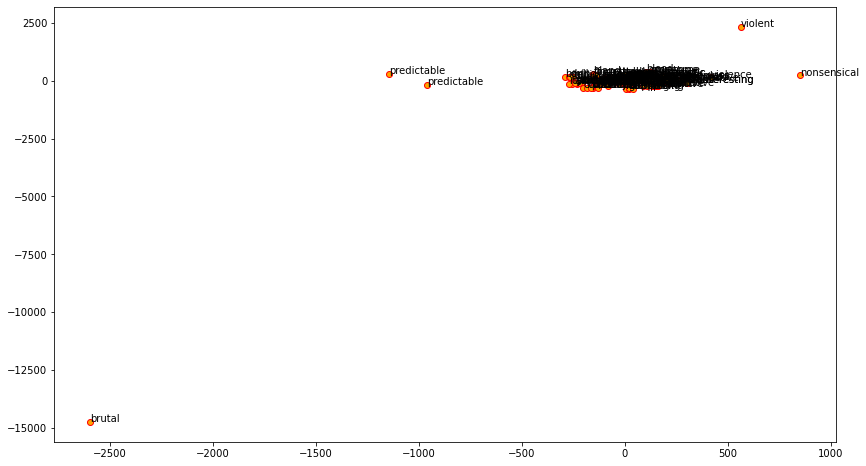

In [29]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200
%matplotlib inline
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')